<a href="https://colab.research.google.com/github/techfreakworm/CustomerChurn/blob/master/TelecomCustomerChurn_TfDeep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

## Cleaning the data

In [5]:
df = df.dropna()
df.loc[df['OnlineSecurity'] == 'No internet service', 'OnlineSecurity'] = 'No'
df.loc[df['OnlineBackup'] == 'No internet service', 'OnlineBackup'] = 'No'
df.loc[df['DeviceProtection'] == 'No internet service', 'DeviceProtection'] = 'No'
df.loc[df['TechSupport'] == 'No internet service', 'TechSupport'] = 'No'
df.loc[df['StreamingTV'] == 'No internet service', 'StreamingTV'] = 'No'
df.loc[df['StreamingMovies'] == 'No internet service', 'StreamingMovies'] = 'No'
df.loc[df['MultipleLines'] == 'No phone service', 'MultipleLines'] = 'No'
df.loc[df['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
df.loc[df['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'
df['TotalCharges'] = df['TotalCharges'].convert_objects(convert_numeric = True)

/home/mayank/venv/DLaaS/lib/python3.5/site-packages/ipykernel_launcher.py:11: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use Series.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  # This is added back by InteractiveShellApp.init_path()


In [6]:
def tenurify(x):
  if x >= 0 and x <= 12:
    return '0–12 Month'
  elif x > 12 and x <= 24:
    return '12-24 Month'
  elif x > 24 and x <= 48:
    return '24-48 Month'
  elif x > 48 and x <= 60:
    return '48-60 Month'
  else:
    return '>60 Month'
  

df['tenureGroup'] = df['tenure'].apply(tenurify)

In [7]:
cleanDF = df.drop(['customerID','tenure'],axis=1)

In [8]:
import copy
def stringToIntMapper(dataFrame):
  mappingDict = {}
  convertedDF = pd.DataFrame()
  isColStr = {}
  
  ## Check if column contains string values
  for col in dataFrame.columns:
    if type(dataFrame[col][0]) == str:
      isColStr[col] = True
    else:
      isColStr[col] = False
  
  ## Create mapping dictionary for string values in columns
  for col in dataFrame.columns:
    if isColStr[col]:
      valueList = list(dataFrame[col].value_counts().to_dict().keys())
      counter = 0
      tempValDict = {}
      for val in valueList:
        tempValDict[val] = counter
        counter = counter + 1
      mappingDict[col] = copy.deepcopy(tempValDict)
  
  ## Map the string columns
  for col in dataFrame.columns:
    if isColStr[col]:
      convertedDF[col] = dataFrame[col].map(mappingDict[col])
    else:
      convertedDF[col] = dataFrame[col]
    
  return convertedDF, mappingDict

In [9]:
convDF, dict = stringToIntMapper(cleanDF)
convDF = convDF.dropna()

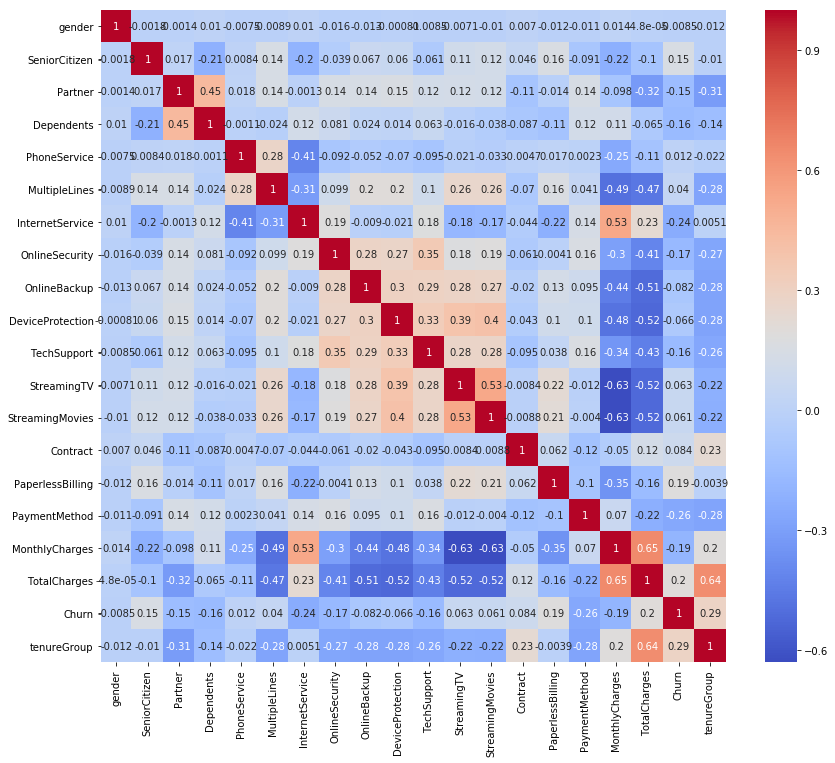

In [10]:
fig, ax = plt.subplots(figsize=(14,12))
sns.heatmap(convDF.corr(), annot=True, cmap='coolwarm', ax=ax)

## Preparing Data for Training/Testing

In [11]:
X = convDF.drop(labels='Churn',axis=1)
y = convDF['Churn']

In [12]:
def get_features_labels(X, y):
    # Select all columns but the first
    features = X.values
    # The first column is the label. Conveniently called 'label'
    labels = y.values
    return features, labels

In [13]:
X, y = get_features_labels(X, y)

In [14]:
print(X.shape)
print(y.shape)

(7032, 19)
(7032,)


In [15]:
type(X)

numpy.ndarray

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [17]:
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [18]:
print(y_train.shape)
print(y_test.shape)

(4922, 2)
(2110, 2)


In [19]:
type(X_test)

numpy.ndarray

## Multilayered Perceptron

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential()

model.add(Dense(10, input_shape=(19,), activation=tf.nn.relu))
model.add(Dense(20, activation=tf.nn.relu))
model.add(Dense(2, activation=tf.nn.softmax))

# Adam optimizer with learning rate of 0.001

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 42        
Total params: 462
Trainable params: 462
Non-trainable params: 0
_________________________________________________________________


In [21]:
# model = tf.keras.estimator.model_to_estimator(keras_model=model)

In [22]:
model.fit(X_train, y_train,
          batch_size=100,
          epochs=10)

score, acc = model.evaluate(X_test, y_test)

print('Test score:', score)
print('Test accuracy:', acc)

Epoch 1/10
4922/4922 [==============================] - 1s 219us/step - loss: 3.5961 - acc: 0.7343
Epoch 2/10
4922/4922 [==============================] - 0s 12us/step - loss: 1.5695 - acc: 0.6445
Epoch 3/10
4922/4922 [==============================] - 0s 12us/step - loss: 1.1375 - acc: 0.6310
Epoch 4/10
4922/4922 [==============================] - 0s 12us/step - loss: 0.9969 - acc: 0.6382
Epoch 5/10
4922/4922 [==============================] - 0s 12us/step - loss: 1.1406 - acc: 0.6290
Epoch 6/10
4922/4922 [==============================] - 0s 12us/step - loss: 1.0540 - acc: 0.6550
Epoch 7/10
4922/4922 [==============================] - 0s 12us/step - loss: 1.0392 - acc: 0.6497
Epoch 8/10
4922/4922 [==============================] - 0s 12us/step - loss: 1.0185 - acc: 0.6666
Epoch 9/10
4922/4922 [==============================] - 0s 12us/step - loss: 0.9632 - acc: 0.6664
Epoch 10/10
2110/2110 [==============================] - 0s 29us/step
Test score: 0.7390281200408936
Test accuracy: 0

In [23]:
classifier = tf.keras.estimator.model_to_estimator(keras_model=model)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
INFO:tensorflow:Using config: {'_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_eval_distribute': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker', '_save_summary_steps': 100, '_protocol': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f4ad3097dd8>, '_experimental_distribute': None, '_global_id_in_cluster': 0, '_save_checkpoints_secs': 600, '_model_dir': '/tmp/tmpz591b2ks', '_is_chief': True, '_save_checkpoints_steps': None, '_master': '', '_tf_random_seed': None, '_task_id': 0, '_log_step_count_steps': 100, '_train_distribute': None, '_num_worker_replicas': 1, '_device_fn': None, '_evaluation_master': '', '_num_ps_replicas': 0, '_service': None}


In [24]:
input_name = model.input_names[0]

In [29]:
model.input_names

['dense_input']

In [25]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x={input_name: X_train},
        y=y_train,
        batch_size=100,
        num_epochs=3,
        shuffle=True)

In [26]:
feature_columns = [tf.feature_column.numeric_column(input_name, shape=19)]

In [27]:
classifier.train(input_fn=train_input_fn)

Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='/tmp/tmpz591b2ks/keras/keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})
INFO:tensorflow:Warm-starting from: ('/tmp/tmpz591b2ks/keras/keras_model.ckpt',)
INFO:tensorflow:Warm-starting variable: dense_2/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense/bias; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_2/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense_1/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: dense/kernel; prev_var_name: Unchanged
INFO:tensorflow:Warm-starting variable: RMSprop/decay; prev_va

In [28]:
feature_spec = {
    input_name: tf.FixedLenFeature(shape=[19], dtype=np.float32)
}
serving_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)
export_dir = classifier.export_savedmodel(export_dir_base="models/export", 
                            serving_input_receiver_fn=serving_fn)
export_dir = export_dir.decode("utf8")

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Restoring parameters from /tmp/tmpz591b2ks/model.ckpt-149
Instructions for updating:
Pass your op to the equivalent parameter main_op instead.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: models/export/temp-b'1550645289'/saved_model.pb
